# Projet Python for nummies Maxence DAVID 




Dans le cadre dupao sur le langage Python et l'utilisation de ses librairies pour le calcul numérique, nous devons réaliser un premier projet de deep learning. L'objectif de ce projet est donc de mener une étude afin de déterminer le sentiment globale d'un tweet à partir d'un dataset de tweet sur le COVID. 

## Import des librairies


In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import keras as kr
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import pandas as pd 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/maxence/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import des données

In [2]:
data_train = pd.read_csv('Corona_NLP_train.csv',encoding='latin')
data_test = pd.read_csv('Corona_NLP_test.csv',encoding ='latin')

# Analyse du Dataset

Nous allons maintenant regarder le contenue de ce dataset

In [3]:
data_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Nous avons donc 5 variables (UserName, ScreenName, Location, TweetAt et OrigianlTweet) et aussi le sentiment de chaque tweet (les labels)

Voici la distribution des sentiments étiquetés dans le dataset de training


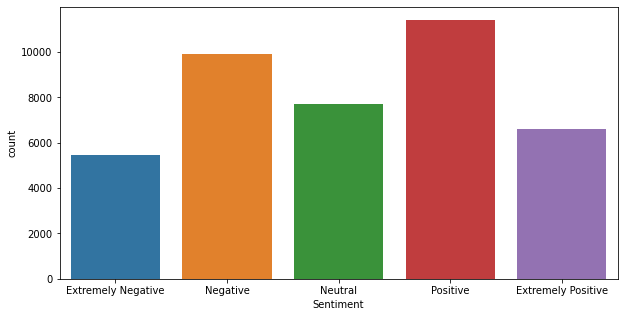

In [4]:
plt.figure(figsize=(10,5))
sns.countplot(x='Sentiment', data=data_train, order=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], )
plt.show()

In [5]:
data_train['Location'].value_counts()[0:10]

London             540
United States      528
London, England    520
New York, NY       395
Washington, DC     373
United Kingdom     337
Los Angeles, CA    281
India              268
UK                 232
Australia          225
Name: Location, dtype: int64

Voici les 10 régions/pays qui regroupent le plus de tweets dans le dataset. On peut conclure de cette analyse que la majeurs parti des tweets proviennent de pays anglophone. Les tweets seront donc en anglais 

In [6]:
data_train.shape, data_test.shape

((41157, 6), (3798, 6))

On remarque que nous avons donc 41257 tweets dans notre dataset de training . Il sont composé de 6 variables. Le user name, screen name, le lieux du tweet, la date, le tweet entier et enfin le sentiment de ce tweet.  
Le but du projet et de trouver un model fiable de prédiction du sentiment en ayant un tweet en entré. 

Nous alons utiliser seulement la feature "OriginalTweet" dans notre projet. La prediction sera donc basé seulement sur les tweets et non pas sur les meta-données qui les accompagne. Nous allons donc réaliser un réseaux de type NLP. Natural language procesing 

# Data preprocessing

In [242]:
nom_features = ['OriginalTweet'] # selection des features
nom_label = ['Sentiment'] # selection des labels
#On copi seulement les colones souhaité dans X et Y 
X_train = data_train[nom_features].copy()
Y_train = data_train[nom_label].copy()
X_test = data_test[nom_features].copy()
Y_test = data_test[nom_label].copy()


In [243]:
X_train

,OriginalTweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1,advice Talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...
3,My food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV..."
...,...
41152,Airline pilots offering to stock supermarket s...
41153,Response to complaint not provided citing COVI...
41154,You know itÂs getting tough when @KameronWild...
41155,Is it wrong that the smell of hand sanitizer i...


In [244]:
sentiment = np.unique(data_train['Sentiment'])
print(sentiment)

['Extremely Negative' 'Extremely Positive' 'Negative' 'Neutral' 'Positive']


Pour simplifier nous alons reduire les sentiments possibles à [Positif, Negatif, Neutre].De plus nous allons les encoder par [0,1,2]. Cette reduction est pertinente car nous voulons capter le sentiment globale d'un tweet. Un tweet "Extremely Negative" est avant tout "négatif". On reduit donc les valeurs que peuvent prendre les labels et donc on augmente les tweets disponiblent pour l'apprentisage dans chacunes des catégories de labels.

In [245]:
code = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }

Y_train.replace(code,inplace=True)
Y_test.replace(code,inplace=True)


## Data Cleaning 

Nous devons mainteant "netoyer" les tweets pour qu'ils puissent etre donnés à un système d'aprentisage. Pour cela nous allons retirer tous les caractères speciaux, les liens https, de plus nous allons utiliser une librairie qui resence les "stopwords" qui sont les mots qui n'apportent pas d'information, exemple : 'le' 'un' 'il' ect. Nous pourons donc les enlever des tweets. 

In [246]:
stopword = stopwords.words('english')
print('Voici la liste des stopwords anglais  :\n' ,stopword)

Voici la liste des stopwords anglais  :
 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not

In [247]:
#En entré on prend des tweets ( des séquences de texte )
def clean(X) : 
    X = re.sub(r'@\w+',' ',X)
    X = re.sub(r'http\S+',' ',X)
    X = re.sub(r'#\w+', ' ', X )
    X = re.sub(r'\d+',' ', X)
    X = re.sub(r'#\w+',' ',X)
    X = re.sub(r'<.*?>\w+',' ',X)
    X = X.lower()

    X = re.sub(r'[^a-z0-1\s]','',X) 
    X = X.split()

    stopword=stopwords.words('english')
    X= " ".join([mot for mot in X if not mot in stopword])
    return X


In [248]:
X_train_clean = X_train['OriginalTweet'].apply(clean).copy()
X_test_clean = X_test['OriginalTweet'].apply(clean).copy()

In [249]:
X_train_clean

0                                                         
1        advice talk neighbours family exchange phone n...
2        coronavirus australia woolworths give elderly ...
3        food stock one empty please dont panic enough ...
4        ready go supermarket outbreak im paranoid food...
                               ...                        
41152    airline pilots offering stock supermarket shel...
41153    response complaint provided citing covid relat...
41154    know getting tough rationing toilet paper mart...
41155             wrong smell hand sanitizer starting turn
41156    well newused rift going amazon rn although nor...
Name: OriginalTweet, Length: 41157, dtype: object

Nous avons mainteant des tweets "propres", c'est à dire avec seulement des mots "importants" plus de mention "@", plus de "#". Il n'y a plus non plus de ponctuation. 

In [250]:
X_train_clean.shape, X_test_clean.shape
len(X_train_clean)


41157

Le but du projet n'est pas de réaliser de l'analyse mais nous allons visualiser le contenue des tweets

In [265]:
join_tweet_negative=""
join_tweet_neutre = ""
join_tweet_positif = ""

for i in range (len(X_train_clean)):
    if Y_train["Sentiment"][i]== 0 : 
        join_tweet_negative += "".join(X_train_clean[i])+" "
    elif Y_train["Sentiment"][i]==1 :
        join_tweet_neutre += "".join(X_train_clean[i])+ " "
    else : 
        join_tweet_positif += "".join(X_train_clean[i])+" "
        
    
def print_wordcloud(text,color):
    
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap=color,
                min_font_size = 10).generate(text) 
    return wordcloud
    


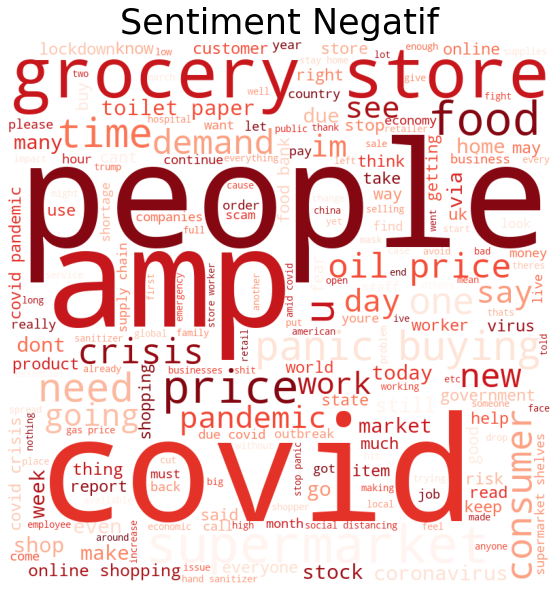

In [272]:
plt.figure(figsize=(10,10))
plt.imshow(print_wordcloud(join_tweet_negative,"Reds"))
plt.axis('off')
plt.title('Sentiment Negatif',fontsize=35);

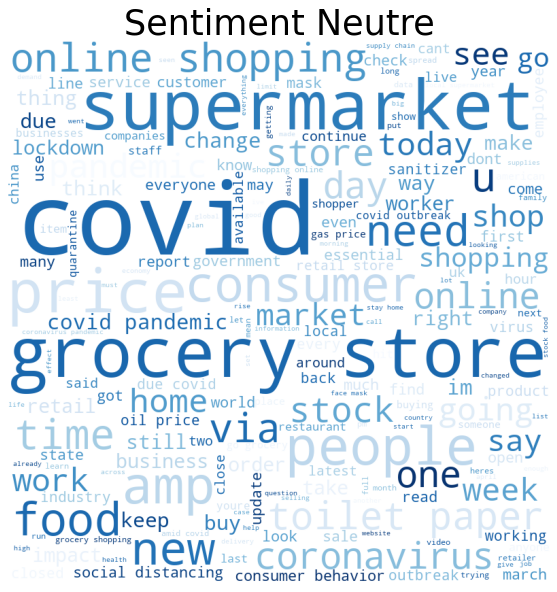

In [273]:
plt.figure(figsize=(10,10))
plt.imshow(print_wordcloud(join_tweet_neutre,"Blues"))
plt.axis('off')
plt.title('Sentiment Neutre',fontsize=35);



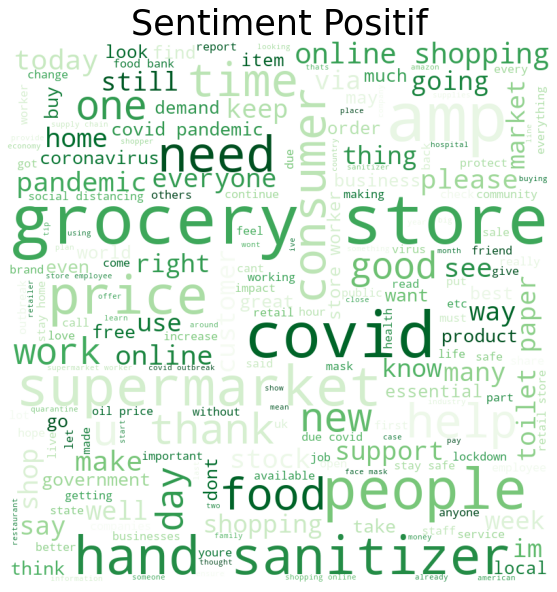

In [274]:
plt.figure(figsize=(10,10))
plt.imshow(print_wordcloud(join_tweet_positif,"Greens"))
plt.axis('off')
plt.title('Sentiment Positif',fontsize=35);


Voici les mots qui constituent en majeur partie les tweets possitifs, negatifs et neutre sous forme de wordcloud 

## Tokenizing

In [275]:
taille = np.zeros_like(X_train_clean)
for i in range(len(X_train_clean)):
    taille[i] = len(X_train_clean[i])
taille_max = np.max(taille) 
taille_max


266

Nous devons recuperer la taille de la séquence de mots la plus longue pour ne pas perdre d'infomration au padding. Si nous n'utilisons pas taille_max pour realiser le padding nous allons perdre des informations (taille du padding sans utiliser taille_max : 40)

In [276]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_clean)

taille_vocabulaire = len(tokenizer.word_index) + 1


X_train_clean = tokenizer.texts_to_sequences(X_train_clean)
X_test_clean = tokenizer.texts_to_sequences(X_test_clean)



In [277]:
X_train_clean = pad_sequences(X_train_clean, maxlen=taille_max, padding='post')
X_test_clean = pad_sequences(X_test_clean, maxlen=taille_max, padding='post')
X_train_clean

array([[    0,     0,     0, ...,     0,     0,     0],
       [  380,   732,  2334, ...,     0,     0,     0],
       [   24,   814,  4342, ...,     0,     0,     0],
       ...,
       [   54,   126,  1407, ...,     0,     0,     0],
       [  573,  3746,    26, ...,     0,     0,     0],
       [  100, 36599, 36600, ...,     0,     0,     0]], dtype=int32)

In [278]:
X_train_clean.shape

(41157, 266)

Nous avons transformer nos tweet en sequence de chiffres que nous avons ensuite regrouper en une matrice avec comme taille maximum la taille du tweet le plus long du dataset de train donc 266. 

## Construction du modele

In [279]:
import tensorflow.keras.layers as Layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
tf.keras.backend.clear_session()

# hyper parameters
EPOCHS = 2
BATCH_SIZE = 32
embedding_dim = 16
units = 256

model = tf.keras.Sequential([
    Layers.Embedding(taille_vocabulaire, embedding_dim, input_length=X_train_clean.shape[1]),
    Layers.Bidirectional(Layers.LSTM(units,return_sequences=True)),
    Layers.GlobalMaxPool1D(),
    Layers.Dropout(0.4),
    Layers.Dense(64, activation="relu"),
    Layers.Dropout(0.4),
    Layers.Dense(3)
])

In [280]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',metrics=['accuracy']
             )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 266, 16)           585632    
_________________________________________________________________
bidirectional (Bidirectional (None, 266, 512)          559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

Explication du réseaux :  
1) Tout d'abord nous avons utilisé un Word Embeddings (Layers.Embedding) c'est une representation de mots dans un espace n dim apprise avec un des neuronnes. Suite a cela chaque mot est representé par un vecteurs. Deux mots sont proches si leurs vecteurs sont proches.   


2) Ensuite nous avons une couche de 256 neurones LSTM Bidirectionnelle. Les LSTM sont des RNN evolués pour apprendre les dépendance avec une mémoire longue. Un LSTM contient 2 entrées : l'ancien état de la cellule ainsi que le vecteur. 3 types de portes : oublie, entrée et enfin la porte de sortie. Elle utilise la fonction d'activation sigmoide. Et enfin 2 sorties. De nombreux calculs sont effectués dans ce type de cellule.   
Un BLSTM consiste à executer en même temps 2 cellules LSTM, une de gauche à droite et l'autre à l'inverse. Cela calcul 2 vecteurs h qui sont ensuite rassemblée pour donner une sortie.  
Cela permet de mieux comprendre la sémentique de chaque teewt.


3) Le MaxPooling permet de transformer chaque vecteur en un scalaire de taille maximum. 

Nous avons ensuite des neurones simple Dense (propagations vers l'avant )  avec des couches de dropout qui desactive une partie des neurones à chaque epoche pour evité le sur-apprentissage 



Nous utilisons que 2 epochs avec un batch de taille 32. 
Nous nous entrainons sur plus de 1 millions de parametres 
Attention :L'apprentisage est assez long 

In [281]:
h  = model.fit(X_train_clean, Y_train, epochs=EPOCHS, validation_split=0.20, batch_size=BATCH_SIZE)

Epoch 1/2
1029/1029 [==============================] - 328s 319ms/step - loss: 0.6907 - accuracy: 0.7016 - val_loss: 0.4187 - val_accuracy: 0.8534
Epoch 2/2
1029/1029 [==============================] - 322s 313ms/step - loss: 0.3538 - accuracy: 0.8863 - val_loss: 0.3943 - val_accuracy: 0.8608


Nous utilisons 20 % du set pour réaliser la valisation 

Regardonc maintenant le résultat. 

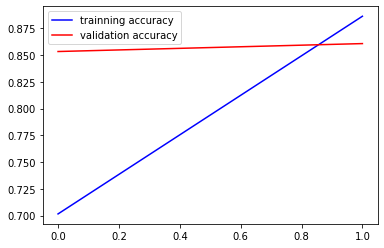

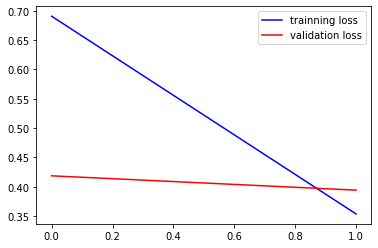

In [283]:
accuracy = h.history['accuracy']
val_accuracy = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()
plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

Voici les courbes d'évolution de l'accuracy et de la loss sur le validation set et trainning set 

# Phase de test 

In [23]:
prediction = model.predict_classes(X_test_clean)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [24]:
prediction

array([0, 2, 2, ..., 1, 0, 2])

Evaluons la qualité du model 

In [25]:
print("Evaluate on test data")
results = model.evaluate(X_test_clean, Y_test)
print("test loss, test acc:", results)


Evaluate on test data
119/119 [==============================] - 15s 129ms/step - loss: 0.4271 - accuracy: 0.8465
test loss, test acc: [0.4271024167537689, 0.8464981317520142]


Nous avons donc une accuracy de 84 % sur l'ensmble de Test ce qui est un très bon résultat.   

Nous allons maintenant plot la matrice de confusion de ce model 

In [28]:
from sklearn.metrics import confusion_matrix
mat_conf = confusion_matrix(Y_test,prediction)
mat_conf

array([[1366,   52,  215],
       [  81,  467,   71],
       [ 149,   15, 1382]])

<Figure size 1440x1440 with 0 Axes>

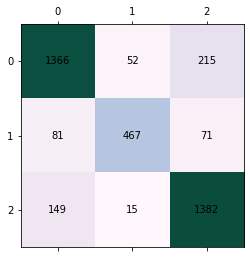

In [50]:
plt.figure(figsize=(20, 20))

plt.matshow(mat_conf, cmap=plt.cm.PuBuGn, alpha=10)
for i in range(mat_conf.shape[0]):
    for j in range(mat_conf.shape[1]):
        plt.text(x=j, y=i, s=mat_conf[i, j], va='center', ha='center') 
plt.show()

In [35]:
print('sachant que ', code)

sachant que  {'Extremely Negative': 0, 'Negative': 0, 'Neutral': 1, 'Positive': 2, 'Extremely Positive': 2}


On remarque donc que par exemple le model predit 1366 fois negatifs et le résultat est réellement negatif. Par contre sachant la classe 0, il a predit 215 fois le classe 2 ( Positive )  

Nous avons donc un résultat visuel du bon fonctionnement du réseaux 

# Piste d'amélioration 
 
Nous aurions pu utiliser d'autre type de réseaux tel que un GAN bidirectionnelle pour comparer les résultats. 

# Conclusion 

Ce projet a été très enrichissant. J'ai ou commencer à comprendre comment le deep learning fonctionne sur du texte. J'ai decouvert de nombreuse chose comme la Tokenisation, le preprocessing du texte, les "stopword" ect.   
Le seul problème est que je ne comprend pas totalement les mathématiques utilisés dans ces réseaux de neurones malgrès des recherches. Je comprend le principe et les méthodes des neurones LSTM avec leurs différentes portes (j'avais deja réalisé un projet avec ce type de neurones à mémoire), mais je ne comprend pas totalement comment fonctionne le bi-directionnel  

Ce projet est donc celon moi un très bon moyen de commencer à travailler avec les librairies de Deep learning 